<a href="https://colab.research.google.com/github/aoa-404/gdppredictor/blob/main/world_bank_resource_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Analyzing Pakistan...
Fetching Total Population...
Fetching GDP per capita...
Fetching Electric power consumption...
Fetching Forest area (% of land)...
Fetching CO2 emissions (metric tons per capita)...
Fetching Renewable electricity output (%)...


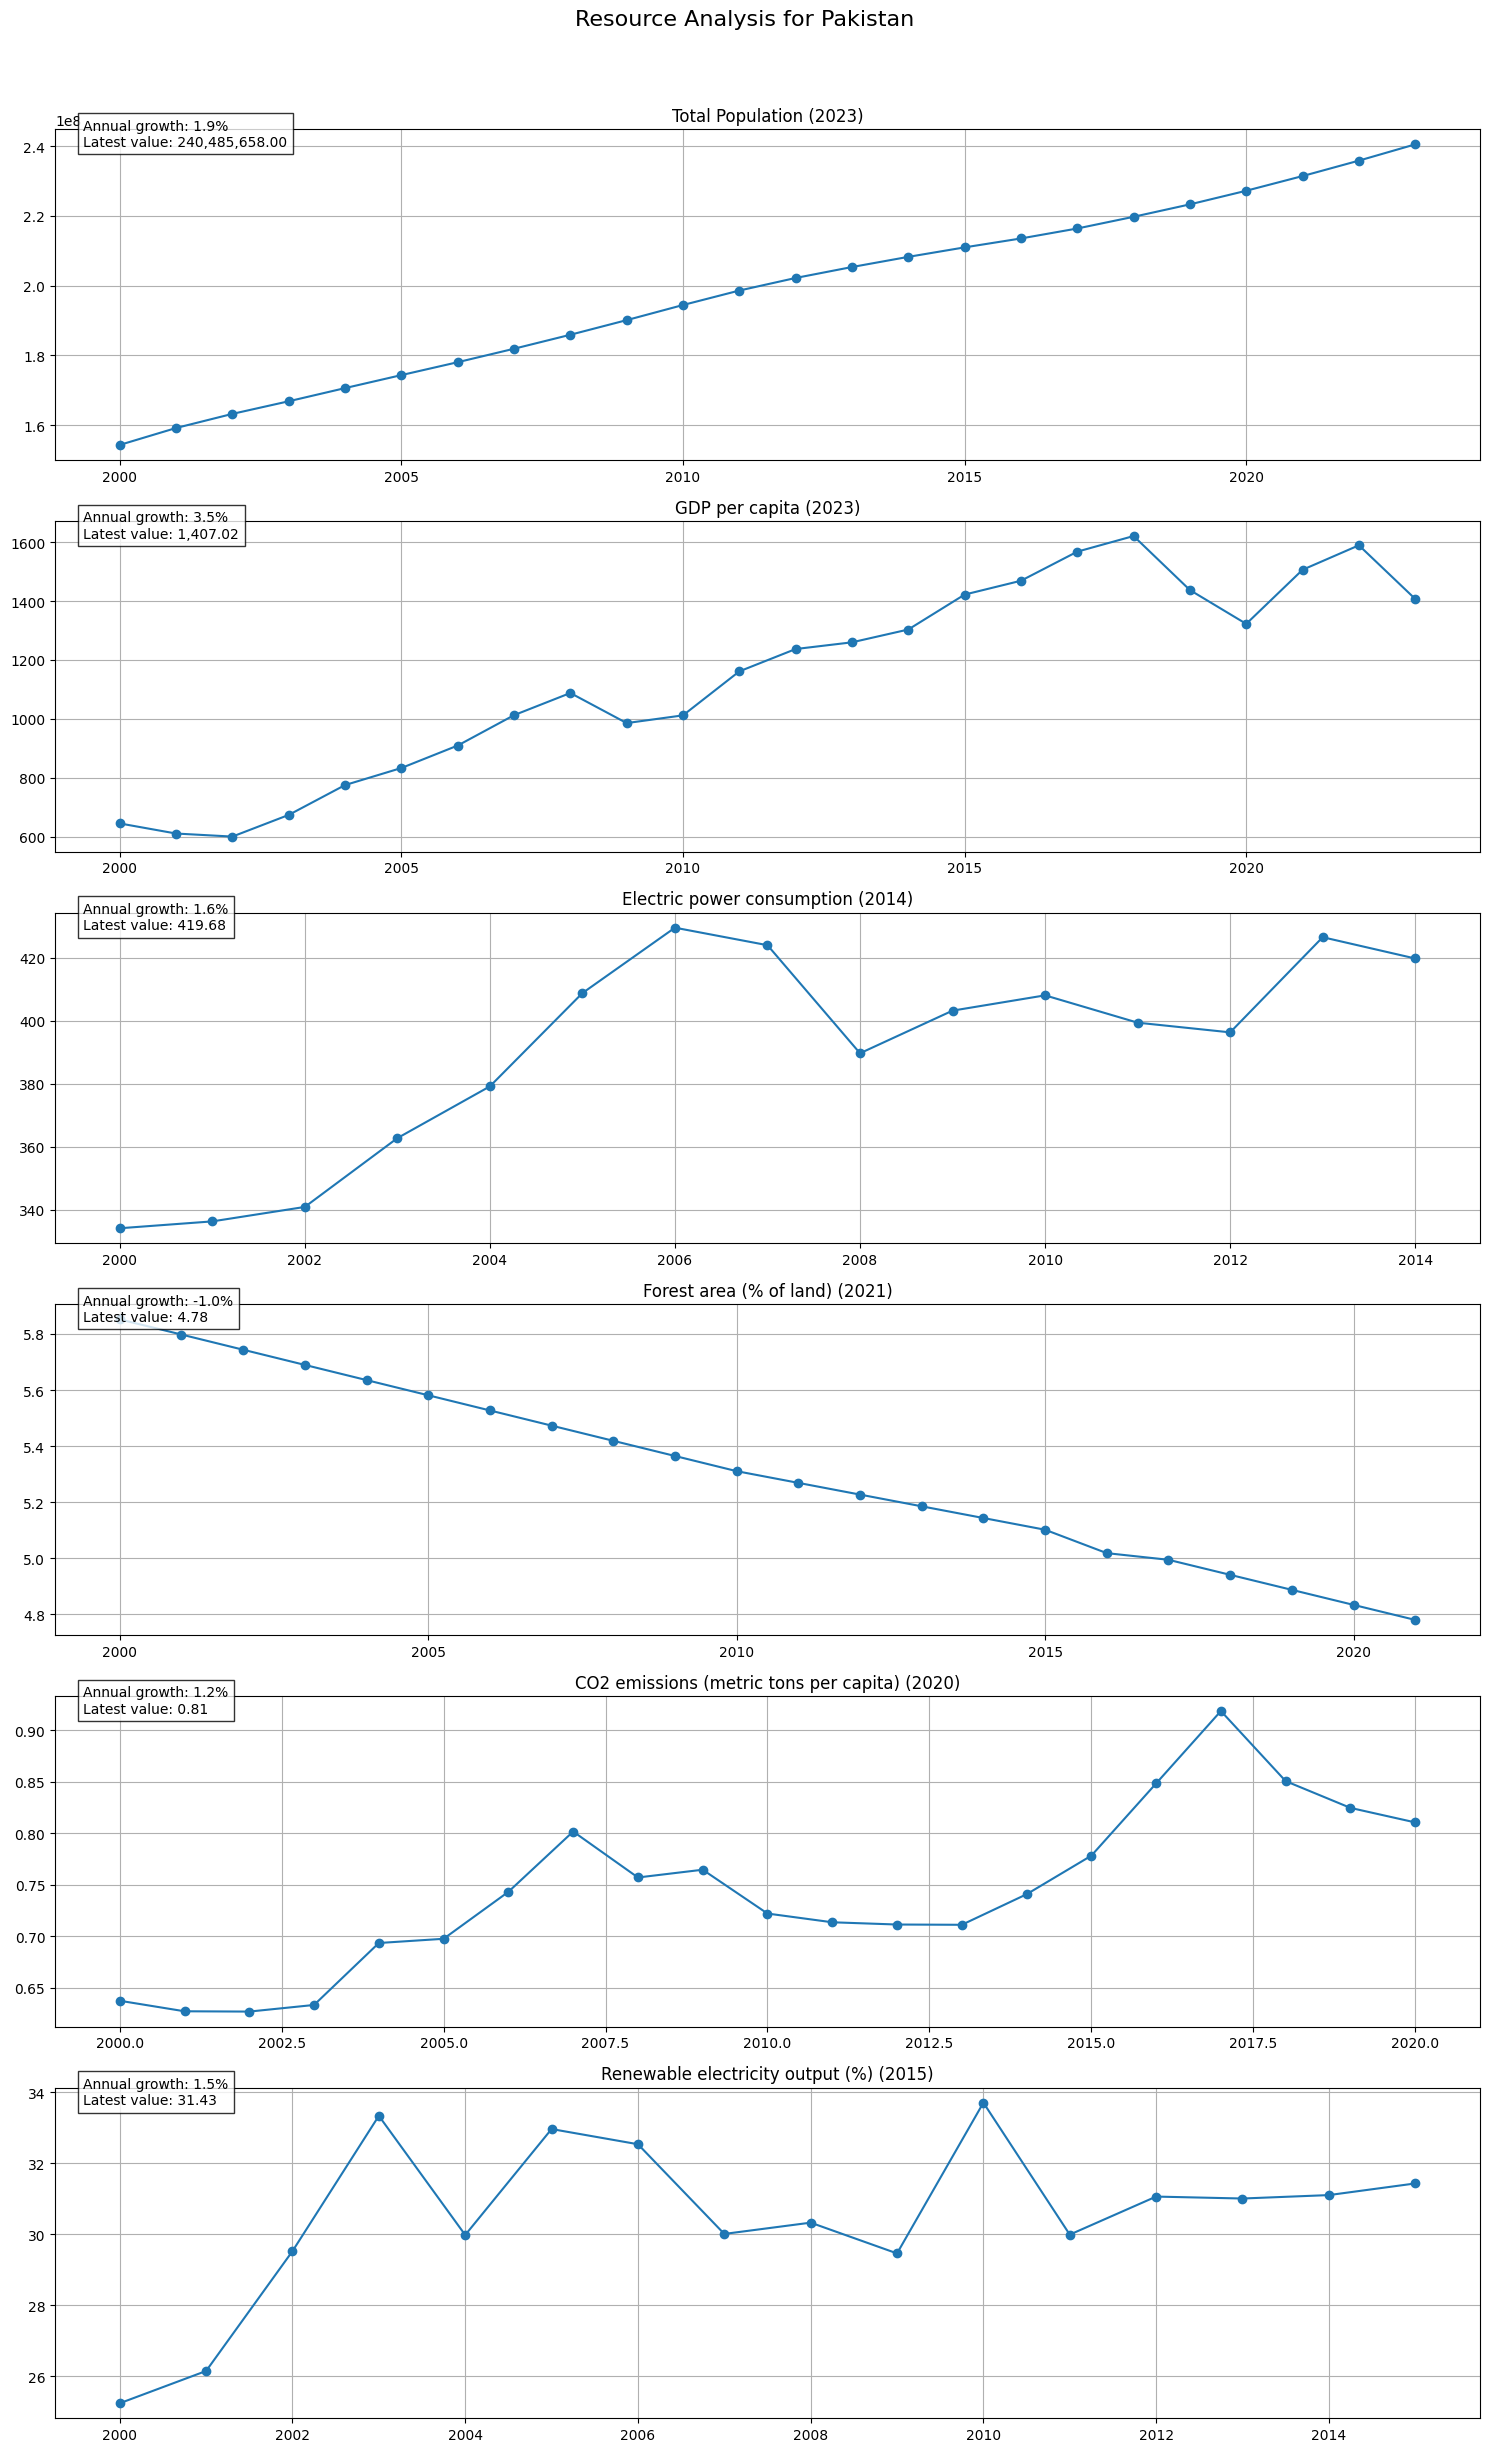


Summary for Pakistan:

Total Population:
  Latest value: 240,485,658.00 (2023)
  Annual growth rate: 1.9%

GDP per capita:
  Latest value: 1,407.02 (2023)
  Annual growth rate: 3.5%

Electric power consumption:
  Latest value: 419.68 (2014)
  Annual growth rate: 1.6%

Forest area (% of land):
  Latest value: 4.78 (2021)
  Annual growth rate: -1.0%

CO2 emissions (metric tons per capita):
  Latest value: 0.81 (2020)
  Annual growth rate: 1.2%

Renewable electricity output (%):
  Latest value: 31.43 (2015)
  Annual growth rate: 1.5%


In [13]:
# Install required packages
!pip install pandas numpy matplotlib seaborn requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
import time
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class CountryResourceTracker:
    """Track population and resource consumption for countries using World Bank data"""

    def __init__(self):
        # Country code mapping
        self.country_codes = {
            'Brazil': 'BRA',
            'China': 'CHN',
            'India': 'IND',
            'USA': 'USA',
            'Russia': 'RUS',
            'Indonesia': 'IDN',
            'Pakistan': 'PAK'
        }

        # Verified working indicators
        self.indicators = {
            'SP.POP.TOTL': 'Total Population',
            'NY.GDP.PCAP.CD': 'GDP per capita',
            'EG.USE.ELEC.KH.PC': 'Electric power consumption',
            'AG.LND.FRST.ZS': 'Forest area (% of land)',
            'EN.ATM.CO2E.PC': 'CO2 emissions (metric tons per capita)',
            'EG.ELC.RNEW.ZS': 'Renewable electricity output (%)'
        }

    def fetch_world_bank_data(self, country_code: str, indicator: str) -> pd.DataFrame:
        """Fetch data from World Bank API with correct endpoint"""
        try:
            url = f"https://api.worldbank.org/v2/country/{country_code}/indicator/{indicator}"
            params = {
                'format': 'json',
                'per_page': 100,
                'date': '2000:2023'
            }

            response = requests.get(url, params=params, timeout=10)
            if response.status_code == 200:
                data = response.json()

                if isinstance(data, list) and len(data) > 1 and data[1]:
                    records = []
                    for entry in data[1]:
                        if entry['value'] is not None:
                            records.append({
                                'year': int(entry['date']),
                                'value': float(entry['value']),
                                'indicator': self.indicators[indicator]
                            })

                    if records:
                        df = pd.DataFrame(records)
                        return df.sort_values('year')

            print(f"No data available for {country_code}, {indicator}")
            return pd.DataFrame()

        except Exception as e:
            print(f"Error fetching data: {str(e)}")
            return pd.DataFrame()

    def analyze_country(self, country: str) -> Dict:
        """Analyze a country's data across all indicators"""
        print(f"\nAnalyzing {country}...")
        country_code = self.country_codes.get(country)

        if not country_code:
            print(f"Country code not found for {country}")
            return {}

        analysis = {'country': country, 'indicators': {}}

        for indicator_code, indicator_name in self.indicators.items():
            print(f"Fetching {indicator_name}...")
            df = self.fetch_world_bank_data(country_code, indicator_code)

            if not df.empty:
                latest_data = df.nlargest(1, 'year').iloc[0]
                first_data = df.nsmallest(1, 'year').iloc[0]

                # Calculate annual growth rate
                years_diff = latest_data['year'] - first_data['year']
                if years_diff > 0:
                    growth_rate = (latest_data['value'] / first_data['value']) ** (1 / years_diff) - 1
                else:
                    growth_rate = 0

                analysis['indicators'][indicator_name] = {
                    'data': df,
                    'latest_value': latest_data['value'],
                    'latest_year': latest_data['year'],
                    'growth_rate': growth_rate
                }

        return analysis

    def generate_visualization(self, analysis: Dict) -> None:
        """Create comprehensive visualization of country analysis"""
        if not analysis or 'indicators' not in analysis:
            print("No data to visualize")
            return

        country = analysis['country']
        n_indicators = len(analysis['indicators'])

        # Create subplot grid
        fig = plt.figure(figsize=(15, 4 * n_indicators))
        gs = plt.GridSpec(n_indicators, 1)

        # Plot each indicator
        for i, (indicator_name, data) in enumerate(analysis['indicators'].items()):
            ax = fig.add_subplot(gs[i])

            df = data['data']
            ax.plot(df['year'], df['value'], marker='o')

            ax.set_title(f'{indicator_name} ({data["latest_year"]})')
            ax.grid(True)

            # Add growth rate and latest value
            growth_text = f'Annual growth: {data["growth_rate"]*100:.1f}%'
            value_text = f'Latest value: {data["latest_value"]:,.2f}'
            ax.text(0.02, 0.95, growth_text + '\n' + value_text,
                   transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))

        plt.suptitle(f'Resource Analysis for {country}', size=16, y=1.02)
        plt.tight_layout()
        plt.show()

def analyze_single_country(country: str):
    """Analyze and visualize data for a single country"""
    tracker = CountryResourceTracker()
    analysis = tracker.analyze_country(country)

    if analysis:
        tracker.generate_visualization(analysis)

        # Print summary
        print(f"\nSummary for {country}:")
        for indicator, data in analysis['indicators'].items():
            print(f"\n{indicator}:")
            print(f"  Latest value: {data['latest_value']:,.2f} ({data['latest_year']})")
            print(f"  Annual growth rate: {data['growth_rate']*100:.1f}%")

# Example usage
country = "Pakistan"  # Change this to analyze different countries
analyze_single_country(country)